# Building Simple CNN Networks

## Data Loading

In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image

import numpy as np

- docs: https://www.tensorflow.org/api_docs/python/tf/WholeFileReader

In [2]:
# 현재 디렉토리를 이용해서 파일 이름을 확인한다.
# for dir in os.listdir(os.getcwd()):
#     print dir

In [3]:
# 여러장의 이미지를 대상으로 학습을 진행한다.
MULTI_IMAGE_MODE = True


image_list = None
label_list = None

if MULTI_IMAGE_MODE:
    batch_size = -1

    image_width = 49
    image_height = 61
    image_channel = 1


    image_dir = os.getcwd() + '/test_img/'
    image_list = os.listdir(image_dir)
    image_list.sort()

    # print image_list[:10]

    image_list = [image_dir + filename for filename in image_list]

    # print image_list[:10]

    label_dir = os.getcwd() + '/test_label/label.csv'
    label_list = [label_dir]

# 한두장의 이미지로 학습한다.
else:
    batch_size = -1

    image_width = 100
    image_height = 100
    image_channel = 3

    image_path1 = os.getcwd() + '/image.png'
    image_path2 = os.getcwd() + '/image-grayscaled.png'
    label_path1 = os.getcwd() + '/label1.csv'
    label_path2 = os.getcwd() + '/label2.csv'

    image_list = [image_path1, image_path2]
    label_list = [label_path1, label_path2]

In [4]:
filename_queue = tf.train.string_input_producer(image_list)
labelname_queue = tf.train.string_input_producer(label_list)


In [5]:
image_reader = tf.WholeFileReader()
label_reader = tf.TextLineReader()

image_key, image_value = image_reader.read(filename_queue)
label_key, label_value = label_reader.read(labelname_queue)

In [6]:
image_decoded = tf.image.decode_png( image_value )
label_decoded = tf.decode_csv( label_value, record_defaults=[ [0] ])

image_decoded = tf.reshape(image_decoded, [image_height, image_width, image_channel])
label_decoded = tf.reshape(label_decoded, [1])

image_batch, label_batch = tf.train.shuffle_batch( 
             [image_decoded, label_decoded],
             batch_size=32, capacity=5000, min_after_dequeue=1000)




In [7]:
print image_batch
print label_batch

Tensor("shuffle_batch:0", shape=(32, 61, 49, 1), dtype=uint8)
Tensor("shuffle_batch:1", shape=(32, 1), dtype=int32)


In [8]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess, coord=coord)

    for i in range(10):
        _image_batch, _label_batch = sess.run([image_batch, label_batch])

    print _image_batch.shape, type(_image_batch)
    print _label_batch.shape, type(_label_batch)

    coord.request_stop()
    coord.join(thread)

(32, 61, 49, 1) <type 'numpy.ndarray'>
(32, 1) <type 'numpy.ndarray'>


In [9]:
# print _image_batch
print type(_image_batch)
print _image_batch.shape

# print _label_batch
print type(_label_batch)
print _label_batch.shape


<type 'numpy.ndarray'>
(32, 61, 49, 1)
<type 'numpy.ndarray'>
(32, 1)


- Encoding and Decoding : https://www.tensorflow.org/api_guides/python/image

## Build Neural Network

- Reference : https://www.tensorflow.org/get_started/mnist/pros

### Placeholder - Input Data Tensor

In [10]:
x = tf.placeholder( tf.float32, shape=[None, image_height, image_width, image_channel]  )
y_ = tf.placeholder( tf.float32, shape=[None, 1] )


In [11]:
print x
print y_

Tensor("Placeholder:0", shape=(?, 61, 49, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


### Variables - Weight Tensor

In [12]:
fc_width = 13
fc_height = 16

# Convolution Layer 1
hidden1_w = tf.Variable( tf.truncated_normal([5, 5, image_channel, 32]) )
hidden1_b = tf.Variable( tf.zeros([32]) )

# Convolution Layer 2
hidden2_w = tf.Variable(tf.truncated_normal([5, 5, 32, 64]))
hidden2_b = tf.Variable(tf.zeros([64]))

# Densely Connected Layer
fully_connected_w = tf.Variable(tf.truncated_normal([fc_width*fc_height*64, 1024]))
fully_connected_b = tf.Variable(tf.zeros([1024]))

# Dropout
keep_prob = tf.placeholder(tf.float32)

# Readout Layer
output_w = tf.Variable(tf.truncated_normal([1024, 1]))
output_b = tf.Variable(tf.zeros([1]))


In [13]:
# Conv Layer 1
x_image = tf.reshape(x, [-1, image_height, image_width,image_channel])
y_label = tf.reshape(y_, [-1, 1])

hidden1_layer = tf.nn.relu(tf.nn.conv2d(x_image, hidden1_w, strides=[1, 1, 1, 1], padding='SAME') + hidden1_b)
hidden1_pool = tf.nn.max_pool(hidden1_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Conv Layer 2
hidden2_layer = tf.nn.relu(tf.nn.conv2d(hidden1_pool, hidden2_w, strides=[1, 1, 1, 1], padding='SAME') + hidden2_b)
hidden2_pool = tf.nn.max_pool(hidden2_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print hidden2_pool

# Densely(Fully) Connected Layer
hidden_pool2_flat = tf.reshape(hidden2_pool, [-1, fc_width*fc_height*64])
hidden_fc1 = tf.nn.relu(tf.matmul(hidden_pool2_flat, fully_connected_w) + fully_connected_b)

# Dropout
hidden_fc1_dropout = tf.nn.dropout(hidden_fc1, keep_prob)


Tensor("MaxPool_1:0", shape=(?, 16, 13, 64), dtype=float32)


- Convolution 네트워크는 종료되고 Feed Forward Neural Network

In [14]:
#Readout Layer
prediction = tf.matmul(hidden_fc1_dropout, output_w) + output_b


In [15]:
# Calculate loss (Evaluate performance) and doing back propagation
cross_entropy = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( labels=y_, logits= prediction ) )
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Preprocessing - Test for showing the _print_images

In [16]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess, coord)

    # CNN학습을 진행한다.
    sess.run(tf.global_variables_initializer())

    for i in range(10):
        _, _loss, _accuracy = sess.run([train_step, cross_entropy, accuracy], 
                                       feed_dict={x:_image_batch,
                                                  y_:_label_batch,
                                                  keep_prob: 0.5})
        print "----------"
        print "loss: ", _loss
        print "accuracy: ", _accuracy

    coord.request_stop()
    coord.join()
    print 'Convolution Network Training is done'

sess.close()


----------
loss:  -1.22961e+09
accuracy:  1.0
Convolution Network Training is done


----------
loss:  -1.04398e+09
accuracy:  1.0


----------
loss:  -1.05162e+09
accuracy:  1.0


----------
loss:  -9.53378e+08
accuracy:  1.0


----------
loss:  -9.38889e+08
accuracy:  1.0


----------
loss:  -8.15889e+08
accuracy:  1.0


----------
loss:  -8.48834e+08
accuracy:  1.0


----------
loss:  -7.55473e+08
accuracy:  1.0


----------
loss:  -7.48595e+08
accuracy:  1.0


----------
loss:  -6.19255e+08
accuracy:  1.0


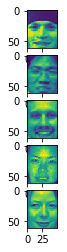

(1, 32, 61, 49, 1)
(61, 49, 1)


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess, coord)

    # 입력받은 이미지를 출력한다.
    fig = plt.figure()

    _print_images = sess.run( [image_batch] )
    _print_images = np.array(_print_images, np.float32)
    print _print_images.shape
    print _print_images[0,0,:,:,:].shape

    for i in range(5):
        image = _print_images[0,i,:,:,:]
        original = Image.fromarray(image.reshape([image_height, image_width]))

        fig.add_subplot(5,1,i+1)
        imgplot = plt.imshow(np.asarray(original))

    coord.request_stop()
    coord.join()

sess.close()


- 컴퓨터의 벡터 연산과 수학에서 표현하는 벡터간의 표현차이

In [18]:
import numpy as np

vector_in_computer = [[1,2,3,4,5], [6,7,8,9,10]]
print vector_in_computer
print np.shape(vector_in_computer)

vector_in_math = [[1], [2], [3], [4], [5]]
print vector_in_math
print np.shape(vector_in_math)


[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
(2, 5)
[[1], [2], [3], [4], [5]]
(5, 1)
